In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
!pip install pytorch-tabnet==3.1.1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random 
from typing import List ,Dict, Tuple

import numpy as np
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib import pyplot as plt

import torch
from torch import nn
from pytorch_tabnet.tab_model  import TabNetClassifier 
from pytorch_tabnet.metrics import Metric

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_path = "/content/drive/MyDrive/dacon/data"
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))

code_d = pd.read_csv(os.path.join(data_path, '속성_D_코드.csv')).iloc[:,:-1]
code_h = pd.read_csv(os.path.join(data_path, '속성_H_코드.csv'))
code_l = pd.read_csv(os.path.join(data_path, '속성_L_코드.csv'))

submission_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

In [ ]:
code_d.columns= ["attribute_d","attribute_d_d","attribute_d_s","attribute_d_m","attribute_d_l"]
code_h.columns= ["attribute_h","attribute_h_p"]
code_l.columns= ["attribute_l","attribute_l_d","attribute_l_s","attribute_l_m","attribute_l_l"]

print(train_df.shape, test_df.shape, code_d.shape, code_h.shape, code_l.shape)
# train_df.head()

(501951, 35) (46404, 34) (1114, 5) (294, 2) (2025, 5)


In [ ]:
def seed_everything(seed): # seed 고정
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def merge_codes(df:pd.DataFrame,df_code:pd.DataFrame,col:str)->pd.DataFrame:
    df = df.copy()
    df_code = df_code.copy()
    df_code = df_code.add_prefix(f"{col}_")
    df_code.columns.values[0] = col
    return pd.merge(df,df_code,how="left",on=col)


def preprocess_data(
    df:pd.DataFrame, is_train:bool=True, 
    cols_merge:List[Tuple[str,pd.DataFrame]] = [], 
    cols_equi:List[Tuple[str,str]]= [] ,
    cols_drop:List[str] = ["id", "person_prefer_f", "person_prefer_g", "contents_open_dt"]
    )->Tuple[pd.DataFrame,np.ndarray]:
    
    df = df.copy()

    y_data = None
    if is_train:
        y_data = df["target"].to_numpy()
        df = df.drop(columns="target")

    for col, df_code in cols_merge:
        df = merge_codes(df,df_code,col)

    cols = df.select_dtypes(bool).columns.tolist()
    df[cols] = df[cols].astype(int)

    for col1, col2 in cols_equi:
        df[f"{col1}_{col2}"] = (df[col1] == df[col2] ).astype(int)

    df = df.drop(columns=cols_drop)
    return (df , y_data)

# 소분류 중분류 대분류 속성코드 merge 컬럼명 및 데이터 프레임 리스트
cols_merge = [
              ("person_prefer_d_1" , code_d),
              ("person_prefer_d_2" , code_d),
              ("person_prefer_d_3" , code_d),
              ("contents_attribute_d" , code_d),
              ("person_prefer_h_1" , code_h),
              ("person_prefer_h_2" , code_h),
              ("person_prefer_h_3" , code_h),
              ("contents_attribute_h" , code_h),
              ("contents_attribute_l" , code_l),
]

# 회원 속성과 콘텐츠 속성의 동일한 코드 여부에 대한 컬럼명 리스트
cols_equi = [
    ("contents_attribute_c","person_prefer_c"),
    ("contents_attribute_e","person_prefer_e"),

    ("person_prefer_d_2_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_2_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_2_attribute_d_l" , "contents_attribute_d_attribute_d_l"),
    ("person_prefer_d_3_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_3_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_3_attribute_d_l" , "contents_attribute_d_attribute_d_l"),

    ("person_prefer_h_1_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
    ("person_prefer_h_2_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
    ("person_prefer_h_3_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
]

def split_data(x_train, y_train, idx):
    X_val = x_train.iloc[idx, ].values
    Y_val = y_train[idx]

    X_train = x_train.loc[~x_train.index.isin(idx)].values
    mask = np.ones(y_train.size, dtype=bool)
    mask[idx] = False
    Y_train = y_train[mask]

    print(X_train.shape, X_val.shape)
    print(Y_train.shape, Y_val.shape)
    return X_train, Y_train, X_val, Y_val

def get_thr(score, gt, n_iter=10000):
    f1s = []
    for i in range(1, n_iter):
        tmp_cutoff = i / n_iter
        f1 = f1_score(gt, (score[:, 1]>=tmp_cutoff)*1)
        f1s.append(f1)
    return f1s.index(max(f1s)) / n_iter, max(f1s)

class F1_Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        score = f1_score(y_true, (y_score[:, 1]>0.5)*1)
        return score


seed_everything(1000)

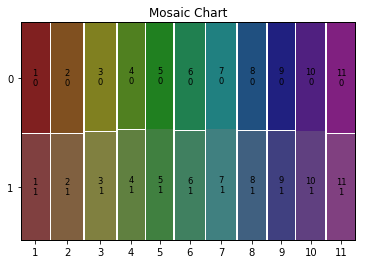

In [ ]:
train_df["contents_open_mm"] = train_df["contents_open_dt"].apply(lambda x: pd.Timestamp(x).month)
mosaic(train_df.sort_values('contents_open_mm'), ['contents_open_mm', 'target'], 
      title='Mosaic Chart')
plt.show()

In [ ]:
# 학습에 필요없는 컬럼 리스트
cols_drop = [
    "id",
    "person_prefer_f", #only one value
    "person_prefer_g", #only one value
    "contents_open_dt",
    "person_rn",
    "contents_rn"]
try: 
    train_df = train_df.drop(columns=['contents_open_mm']) #mosaic plot
except:
    print("already removed col: contents_open_mm")

x_train, y_train = preprocess_data(train_df, cols_merge = cols_merge , cols_equi= cols_equi , cols_drop = cols_drop)
x_test, _ = preprocess_data(test_df,is_train = False, cols_merge = cols_merge , cols_equi= cols_equi  , cols_drop = cols_drop)
x_train.shape , y_train.shape , x_test.shape

((501951, 63), (501951,), (46404, 63))

In [ ]:
cat_idxs = []
cat_dims = []
ordinal_col = ['person_attribute_a_1', 'person_attribute_b', 'person_prefer_e', 'contents_attribute_e']
for idx, col in enumerate(x_train.columns):
    if 'match' not in col or col not in ordinal_col: 
        le = LabelEncoder()
        le.fit(x_train[col].values)
        le_dict = dict(zip(le.classes_, le.transform(le.classes_)))

        x_train[col] = x_train[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        x_test[col] = x_test[col].apply(lambda x: le_dict.get(x, len(le_dict)))
        
        cat_idxs.append(idx)
        cat_dims.append(len(le_dict)+1)
    
    if col in ordinal_col:
        x_train[col] = x_train[col] / max(x_train[col])
        x_test[col] = x_test[col] / max(x_test[col])

In [ ]:
x_train[ordinal_col].describe()

,person_attribute_a_1,person_attribute_b,person_prefer_e,contents_attribute_e
count,501951.000000,501951.000000,501951.000000,501951.000000
mean,0.367967,0.556548,0.329664,0.356635
std,0.341553,0.176614,0.167883,0.105454
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.400000,0.272727,0.272727
50%,0.285714,0.600000,0.363636,0.363636
75%,0.714286,0.800000,0.454545,0.363636
max,1.000000,1.000000,1.000000,1.000000


# TabNet Cross-validation

In [ ]:
n_fold = 5

n_d = 64 # Width of the decision prediction layer
n_a = 64 # Width of the attention embedding for each mask
cat_emb_dim = 4
opt = torch.optim.AdamW #torch.optim.Adam
mask_type = 'sparsemax' # "sparsemax" or "entmax"
lr = 2e-2
epoch = 100
patience = 15
patience_cv = 8
batch_size = 1024
virtual_batch_size = 256
eval_metric = ['f1']#['logloss','f1'] #['logloss','auc']
n_workers = 2

In [ ]:
print(x_train.shape, y_train.shape)

(501951, 63) (501951,)


In [ ]:
seed_everything(1000)

shuffled_idx = list(range(x_train.shape[0]))
print(shuffled_idx[:3], len(shuffled_idx))

random.shuffle(shuffled_idx)
print(shuffled_idx[:3], len(shuffled_idx)) #[223955, 161921, 366757] 501951

[0, 1, 2] 501951
[223955, 161921, 366757] 501951


In [ ]:
fold_size = int(len(shuffled_idx) / 5)
fold_idx = [f * fold_size for f in range(n_fold+1)]
fold_idx[-1] = len(shuffled_idx)

train_idx_lst = []
for i in range(n_fold):
    train_idx_lst.append(shuffled_idx[fold_idx[i]:fold_idx[i+1]])

In [ ]:
best_thrs = []
for i in range(1, n_fold+1):
    print("#"*50)
    print(f"{i}- FOLD TRAINING START -- ")
    seed_everything(1000)
    
    valid_idx = valid_idx_lst[i-1]
    X_train, Y_train, X_val, Y_val = split_data(x_train, y_train, valid_idx)

    clf = TabNetClassifier(
        n_d = n_d, 
        n_a = n_a,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=cat_emb_dim,
        optimizer_fn=opt,
        optimizer_params=dict(lr=lr),
        scheduler_params = {
            "gamma": 0.95,
            "step_size": 10},
        scheduler_fn=torch.optim.lr_scheduler.StepLR, 
        epsilon=1e-15,
        mask_type= mask_type
        )
    
    clf.fit(
        X_train = X_train, 
        y_train = Y_train,
        eval_set = [(X_train, Y_train), (X_val, Y_val)],
        eval_name = ['train', 'val'],
        eval_metric = eval_metric,
        max_epochs = epoch,
        patience = patience_cv,
        batch_size = batch_size,
        virtual_batch_size = virtual_batch_size,
        num_workers = n_workers,
        drop_last = False,
    )

    val_preds = clf.predict_proba(X_val)
    best_thr = get_thr(val_preds, Y_val)
    best_thrs.append(best_thr)
    print(f'fold: {i} - best threshold: {best_thr}')

    del X_train, Y_train, X_val, Y_val, val_preds

##################################################
(100390, 63) (401561, 63)
(100390,) (401561,)
Device used : cuda
epoch 0  | loss: 0.74767 | train_f1: 0.56228 | val_f1: 0.56033 |  0:00:25s
epoch 1  | loss: 0.68335 | train_f1: 0.59726 | val_f1: 0.59629 |  0:00:50s
epoch 2  | loss: 0.67788 | train_f1: 0.55044 | val_f1: 0.54688 |  0:01:16s
epoch 3  | loss: 0.67277 | train_f1: 0.61123 | val_f1: 0.60608 |  0:01:42s
epoch 4  | loss: 0.66876 | train_f1: 0.63094 | val_f1: 0.62293 |  0:02:09s
epoch 5  | loss: 0.66502 | train_f1: 0.61425 | val_f1: 0.60679 |  0:02:38s
epoch 6  | loss: 0.65939 | train_f1: 0.61016 | val_f1: 0.59761 |  0:03:15s
epoch 7  | loss: 0.65603 | train_f1: 0.6497  | val_f1: 0.63218 |  0:03:59s
epoch 8  | loss: 0.65112 | train_f1: 0.62902 | val_f1: 0.60984 |  0:04:36s
epoch 9  | loss: 0.64429 | train_f1: 0.66422 | val_f1: 0.63609 |  0:05:06s
epoch 10 | loss: 0.63828 | train_f1: 0.67017 | val_f1: 0.62988 |  0:05:42s
epoch 11 | loss: 0.63048 | train_f1: 0.36291 | val_f1: 0.35

In [ ]:
print(f'full training shape : {x_train.shape}, {y_train.shape}')

clf = TabNetClassifier(
    n_d = n_d, 
    n_a = n_a,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=cat_emb_dim,
    optimizer_fn=opt,
    optimizer_params=dict(lr=lr),
    scheduler_params = {
        "gamma": 0.95,
        "step_size": 10},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, 
    epsilon=1e-15,
    mask_type= mask_type
    )

clf.fit(
    X_train=x_train, 
    y_train=y_train,
    eval_set=[(x_train, y_train)],
    eval_name=['train'],
    eval_metric=eval_metric,
    max_epochs=epoch,
    patience=patience,
    batch_size=batch_size,
    virtual_batch_size=virtual_batch_size,
    num_workers=n_workers,
    drop_last=False,
)

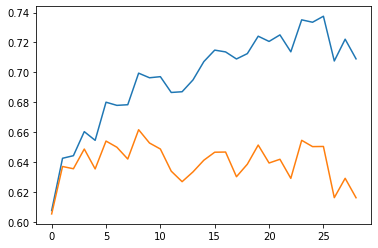

In [ ]:
# plt.plot(clf.history['loss'])

# plot accuracy
plt.plot(clf.history[f'train_{eval_metric[-1]}'])
plt.plot(clf.history[f'val_{eval_metric[-1]}'])

best threshold from validation set : 0.3713


# Test

In [ ]:
# print(f'best threshold from validation set : {best_thr}')
thr = sum(best_thrs)/n_fold
preds = clf.predict_proba(x_test.values)
preds = (preds[:,1] >= thr) * 1

In [ ]:
submission_df['target'] = preds
submission_df.to_csv(f'{data_path}/result3.csv',index=False)

# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)